In [1]:
import numpy as np
from numpy.random import randint as randint
import matplotlib.pyplot as plt
import csv

**Constructing kernels**

Let $K_1$, $K_2$ be (Mercer) kernels over $\mathbb{R}^n\times \mathbb{R}^n$, let $a \in \mathbb{R}^+$ be a positive real number, let $f : \mathbb{R}^n \rightarrow \mathbb{R}$ be a real-valued function, let $\phi : \mathbb{R}^n \rightarrow \mathbb{R}^d$ be a function mapping from $\mathbb{R}^n$ to $\mathbb{R}^d$, let $K_3$ be a kernel over $\mathbb{R}^d \times \mathbb{R}^d$, and let $p(x)$ be a polynomial over $x$ with *positive* coefficients. We know want to know which of the following functions are also kernels. That is, which are symmetric, positive semi-definite matrices for some finite set $\{x^{(1)},...,x^{(m)}\}$.

(a) $K(x,z) = K_1(x,z) + K_2(x,z)$

This is clearly a kernel. Using the fact that $K_1$ and $K_2$ are kernels, and therefore symmetric, we find $K_{ji} = K_{1,ji} + K_{2,ji} = K_{1,ij} + K_{2,ij} = K_{ij}$, so that $K$ is symmetric. Similarly, the fact that $z^T Kz \geq 0$, $\forall z \in \mathbb{R}^n$ follows from linearity and the positive semi-definite nature of both $K_1$ and $K_2$

(b) $K(x,z) = K_1(x,z) - K_2(x,z)$

This is not a kernel. Let $K_2 = b K_1$, $b >1$ and $b \in \mathbb{R}^+$. Then, notice that $z^T Kz = (1-b) (z^T K_1z) \leq 0$ since $K_1$ is positive semi-definite. So, in this case $K$ is negative semi-definite

(c) $K(x,z) = aK_1(x,z)$

This is a kernel. Transposition and matrix multiplication commute with scalar multiplication, and $K$ is therefore symmetric following directly from the symmetric nature of $K_1$. Since $a$ is a *positive* real, and $K_1$ is positive semi-definite, the positive semi-definite nature of $K$ follows in a similar fashion.

(d) $K(x,z) = -aK_1(x,z)$

This is *not* a kernel. In particular, notice that $z^T Kz = -az^T K_1 z \leq 0$ since $K_1$ is positive semi-definite and $a$ is a positive real. This means that $K$ is a negative semi-definite matrix and cannot be a kernel.

(e) $K(x,z) = K_1(x,z)K_2(x,z)$

This is a kernel. Recall that, as kernels, we can write $K_1(x,z) = \phi_1^T(x) \phi_1(z)$ and $K_2 = \phi_2^T(x) \phi_2(z)$. Thus, $K(x,z) = \phi_1^T(x) \phi_1(z) \phi_2^T(x) \phi_2(z) = \sum_{i,j} \phi_{1,i}(x) \phi_{1,i}(z) \phi_{2,j}(x) \phi_{2,j}(z)$. If we define $\Phi = \phi_1 \otimes \phi_2 \rightarrow \Phi_{i,j} = \phi_{1,i} \phi_{2,j}$, we then have $K(x,z) = \Phi(x)^T \Phi$, so $K$ has the appropriate form to be a kernel as well.

(f) $K(x,z) = f(x)f(z)$.

This is a kernel. Since $f$ is a scalar, we can just define $\phi = f$ and $K$ trivially has the form $K(x,z) = \phi^T(x) \phi(z)$

**Kernelizing the perceptron**

The original update rule we want to modify is $\theta := \theta + \alpha y^{(i)} x^{(i)}$ if $y^{(i)}h\left(x^{(i)}\right) < 0$, and $\theta := \theta$ otherwise. Working in the high-dimensional space, we now use the modified update rule $\theta := \theta + 
\alpha \left(y^{(i)}-h\left(\theta^T \phi\left(x^{(i)}\right)\right)\right)\phi\left(x^{(i)}\right)$. Note that this follows the same spirit as the original update rule: if $h(\phi)$ makes a correct predicition (same sign as the target), no update is made, whereas making an incorrect prediction causes $\theta$ to be moved in the right direction to push the margin $y^{(i)}\theta^T x^{(i)}$ towards a positive number.

Now, if we initialize $\theta = 0$, we will always have $\theta = \sum_{i=0}^n \beta_i \phi\left(x^{(i)}\right)$ after the first $n$ coefficients, so that predictions can be made just using the kernel: $h\left(\theta^T \phi(x)\right) = h\left(\sum_{i=0}^n \beta_i K\left(x^{(i)},x\right)\right)$.

To train the perceptron, we initialize the coefficients ${\beta_0,...\beta_m} = 0$. Then, the $(n+1)$-th term is computed using the update rule and the kernel as $\beta_{n+1} = y^{(n+1)}-h\left(\sum_{i=0}^{n} \beta_i K\left(x^{(i)},x\right)\right)$.

**Spam classification**

We'll tackle the problem of spam classification, first using Naive Bayes. First, let's make a function to read in the training and test data in the form of a document-word matrix, where the $(i,j)$-th element of the matrix indicates how many instances of word $j$ from our list of token occurs within document $i$.

In [2]:
def readDocWordMatrix(fileName):
    file = open(fileName,'r')
    file.readline() # meaningless header
    [nDocs,nToks] = [int(s) for s in file.readline().split()]
    docWordMat = np.zeros((nDocs,nToks))
    tokens = file.readline().split()
    categories = np.zeros(nDocs)
    for idx,line in enumerate(file):
        nums = [int(s) for s in line.split()]
        categories[idx] = nums[0]
        lastIdx = len(nums)-1
        docWordMat[idx,np.cumsum(nums[1:lastIdx:2])] = nums[2:lastIdx:2]
    file.close()
    return docWordMat,tokens,categories

Now, we compute the Naive Bayes parameters from the traiing set, using Laplace smoothing. Using the multinomial event model, the relevant parameters are then given by 

$\phi_{k|y=1} = p(x_j=k|y=1) = \frac{1+\sum 1\left\{x_j^{(i)}=k \wedge y^{(i)}=1\right\}}{|V|+\sum 1\left\{y^{(i)}=1\right\}n_i}$,

$\phi_{k|y=0} = p(x_j=k|y=0) = \frac{1+\sum 1\left\{x_j^{(i)}=k \wedge y^{(i)}=0\right\}}{|V|+\sum 1\left\{y^{(i)}=0\right\}n_i}$,

$\phi_{y=1} = p(y=1) = \frac{\sum 1\left\{y^{(i)}=1\right\}}{m}$,

where $|V|$ is the size of the vocabulary, $n_i$ is the total number of words in each training example.

In [3]:
def trainNaiveBayes(file):
    docWordMat,tokens,categories = readDocWordMatrix(file)
    numWords = np.sum(docWordMat,axis=1)
    numTokens = len(tokens)
    likelihoodSpam = np.zeros(numTokens)
    likelihoodNoSpam = np.zeros(numTokens)
    probSpam= np.sum(categories)/len(categories)
    for idx in range(numTokens):
        likelihoodSpam[idx] = (np.sum(docWordMat[categories==1,idx])+1)/(np.sum(numWords[categories==1])+numTokens)
        likelihoodNoSpam[idx] = (np.sum(docWordMat[categories==0,idx])+1)/(np.sum(numWords[categories==0])+numTokens)
    return likelihoodSpam,likelihoodNoSpam,probSpam

In [4]:
likelihoodSpam,likelihoodNoSpam,probSpam = trainNaiveBayes('MATRIX.TRAIN')

Now, we evaluate on the test set. For each document (row in the document-word matrix), we'll compute the conditional probability of seeing that word vector $x$ if the document is spam ($y = 1$) using the following formula:

$p(x|y=1) = \prod_{x_i} \left(\phi_{i|y=1}\right)^{x_i}$

and similarly for $y=0$. Then the probability of the document being spam is simply computed as 

$p(y=1|x) = \frac{p(x|y=1)\phi_{y=1}}{p(x|y=0)(1-\phi_{y=1})+p(x|y=1)\phi_{y=1}}$,

With the e-mail being classified as spam if $p(y=1|x) \geq 0.5$. 

The issue here is that most of the $\phi_{i|y=1}$ and $\phi_{i|y=0}$ are quite small, so we worry about underflow due to the product of so many small numbers. Thus, we look at the logarithm of the probability, converting the products to sums, and ignore the denominator (since it is only there for normalization). Thus, we compute

$l_1 = ln\left(p(x|y=1)\phi_{y=1}\right) = ln\left(\phi_{y=1}\right) + \sum_{x_i} x_i ln\left(\phi_{i|y=1}\right)$,

$l_0 = ln\left(p(x|y=0)\phi_{y=0}\right) = ln\left(1-\phi_{y=1}\right) + \sum_{x_i} x_i ln\left(\phi_{i|y=0}\right)$,

and classify as spam if $e^{l_1} > e^{l_0}$, or equivalently $l_1 > l_0$.

In [5]:
def testNaiveBayes(likelihoodSpam,likelihoodNoSpam,probSpam):
    docWordMatTest,tokensTest,categoriesTest = readDocWordMatrix('MATRIX.TEST')
    numCorrect = 0
    for testIdx,testLabel in enumerate(categoriesTest):
        testVec = docWordMatTest[testIdx,:]
        l1 = np.log(probSpam)+np.dot(testVec,np.log(likelihoodSpam))
        l0 = np.log(1-probSpam)+np.dot(testVec,np.log(likelihoodNoSpam))
        predictLabel = int(l1 >= l0)
        numCorrect += int(predictLabel==int(testLabel))
    print("Test error is "+str(100*(1-numCorrect/len(categoriesTest)))+"%")

In [6]:
testNaiveBayes(likelihoodSpam,likelihoodNoSpam,probSpam)

Test error is 1.6249999999999987%


We can also estimate the most likely spam words by looking at which words maximize the quantity $ln\left(\frac{\phi_{k|y=1}}{\phi_{k|y=0}}\right)$

In [7]:
docWordMat,tokens,categories = readDocWordMatrix('MATRIX.TRAIN')
wordLikelihood = np.log(likelihoodSpam/likelihoodNoSpam)
np.argmax(wordLikelihood)
sortedInds = np.argsort(wordLikelihood)[::-1]
spamTokens = [tokens[s] for s in sortedInds[0:5]]
spamTokens

['httpaddr', 'spam', 'unsubscrib', 'ebai', 'valet']

We can also see how the accuracy of the classifier converges with the amount of training data. In this case, we can see that even 50-100 documents is still quite good (~2x error compared to the full training set of over 2000 doucments), and the error has converged to that of a full training set already by ~1400 documents.

In [8]:
trainingSize = ['50','100','200','400','800','1400']
for size in trainingSize:
    likelihoodSpam,likelihoodNoSpam,probSpam = trainNaiveBayes('MATRIX.TRAIN.'+size)
    print('Training size = '+size+' documents')
    testNaiveBayes(likelihoodSpam,likelihoodNoSpam,probSpam)

Training size = 50 documents
Test error is 3.874999999999995%
Training size = 100 documents
Test error is 2.6249999999999996%
Training size = 200 documents
Test error is 2.6249999999999996%
Training size = 400 documents
Test error is 1.8750000000000044%
Training size = 800 documents
Test error is 1.749999999999996%
Training size = 1400 documents
Test error is 1.6249999999999987%


**Spam classification 2 - SVM Boogaloo**

Now we'll train a support vector machine spam classifier. Rather than using coordinate descent using sequential minimal optimization, we'll use stochastic gradient descent on the regularized empirical loss function

$J(\alpha) = \frac{1}{m}\sum\left[1-y^{(i)}K^{(i),T}\alpha\right]_+ +\frac{\lambda}{2}\alpha^T K \alpha$,

where $K^{i}$ is the $i$-th column of the kernel matrix, $[x]_+ = max\{0,x\}$, and $lambda$ is the regularization constant. Technically, since the loss function is not differentiable at 0 the gradient descent is sub-gradient descent, but whatevs. It's not mentioned why we're doing things this way vs coordinate descent using sequential minimal optimization. Wikipedia mentions that SGD can be more advantageous compared to SMO if the number of training examples is quite large (since we can change all parameters of $\alpha$ at once each iteration) and vice versa if the space is very high dimensional (again, since we change *all* parameters of $\alpha$ at once in SGD). This makes sense, though here I doubt it makes a huge difference. Whatever.

For the kernel we're going to use the radial basis function

$K(x,z) = exp\left(\frac{1}{2\tau^2}|x-z|^2\right)$,

because Gaussians are easy and magic, and we're given values of all the constant parameters to use because there's no time for shenanigans. We'll also use a step size of $\frac{1}{\sqrt{t+1}}$, where $t$ is the iteration number. No reason has been given from this (aside from some comments that it is a typical choice), but some sort of learning rate schedule is typical to give a trade-off between constant large changes to $\alpha$ that cause instability and super slow convergence. I guess this is just a very simple choice which is good enough. Still not sure why $\sqrt{t}$ and not $t$, though...

Some other quirks specified without explanation: We'll adjust the document-word matrix so that columns are only 0 or 1 (i.e., we only care which words appear, not how often within a document). Not sure why, aside from reasons of feature scaling for stability reasons. We're also going to do *averaged* SGD, where we average all the $\alpha$ from each step together at the end and report that average value as the result, rather than the final value of $\alpha$.

Okay, enough talk. Now is the time for action!

In [9]:
def trainAndTestSVM(file,tau=8,iterMult=40,regParam=1/64):
    # Import document-word matrix, convert training labels to {1,-1} and convert feature
    # vectors to {0,1} vectors
    docWordMat,tokens,yTrain = readDocWordMatrix(file)
    numTrain = len(yTrain)
    yTrain[yTrain<1] = -1
    xTrain = (docWordMat>0).astype(int)
    
    # Compute the kernel for the training data using the radial basis function
    xTrainSq = np.tile(np.sum(xTrain**2,axis=1)[:,None],numTrain)
    kTrain = np.exp(-(xTrainSq+xTrainSq.T-2*np.dot(xTrain,xTrain.T))/(2*tau**2))

    # Stochastic gradient descent for fixed number of iterations
    numIter = iterMult*numTrain
    alpha = np.zeros(numTrain)
    avgAlpha = np.zeros(numTrain)
    for idx in range(numIter):
        randIdx = randint(0,high=numTrain)
        margin = yTrain[randIdx]*np.dot(kTrain[:,randIdx],alpha)
        grad = regParam*alpha[randIdx]*kTrain[:,randIdx]-int(margin<1)*yTrain[randIdx]*kTrain[:,randIdx]
        alpha -= grad/np.sqrt(idx+1)
        avgAlpha += alpha
    avgAlpha /= numTrain
    
    # Import document-word matrix, convert training labels to {1,-1} and convert feature
    # vectors to {0,1} vectors
    docWordMat,tokens,yTest = readDocWordMatrix('MATRIX.TEST')
    numTest = len(yTest)
    yTest[yTest<1] = -1
    xTest = (docWordMat>0).astype(int)
    
    # Compute the kernel for the test data using the radial basis function
    xTestSq = np.tile(np.sum(xTest**2,axis=1)[:,None],numTrain)
    xTrainSq2 = np.tile(np.sum(xTrain**2,axis=1)[:,None],numTest)
    kTest = np.exp(-(xTestSq+xTrainSq2.T-2*np.dot(xTest,xTrain.T))/(2*tau**2))
    
    predictions = np.dot(kTest,alpha)
    numErrors = np.sum(predictions*yTest<=0)
    return numErrors/numTest

In [10]:
print('Training error is '+str(100*trainAndTestSVM('MATRIX.TRAIN.50'))+'%')

Training error is 3.375%


In [11]:
numAvgErrors = 10
for size in trainingSize:
    print('Training size = '+size+' documents')
    avgError = 0
    for idx in range(numAvgErrors):
        avgError += trainAndTestSVM('MATRIX.TRAIN.'+size)
    print('Avg. training error is '+str(100*avgError/numAvgErrors)+'%')

Training size = 50 documents
Avg. training error is 8.4625%
Training size = 100 documents
Avg. training error is 4.925%
Training size = 200 documents
Avg. training error is 2.2375%
Training size = 400 documents
Avg. training error is 1.7625%
Training size = 800 documents
Avg. training error is 0.3875%
Training size = 1400 documents
Avg. training error is 0.0375%


That took *much* longer to train than Naive Bayes, but is clearly superior. Notice that while we actually have worse average performance for a small training set, by the time the training set is only 200 documents we have converged to a performance better than Naive Bayes on the full 2000 document training set, and our best error is almost an order of magnitude smaller than the best Naive Bayes error.

**Training and testing on different distributions**

Consider binary classificaion with two distributions: $D$, the "clean" distribution and $D_\tau$, a distribution identical to $D$ except with a probability $0 \leq \tau \lt 0.5$ of the label being flipped (e.g., whoever labeled the data screws up from time to time).

For a given hypothesis $h$, we now have two error quantities: $\epsilon_0$, the "true" generalization error on $D$, and $\epsilon_\tau$, the generalization error when drawing samples from $D_\tau$

(a) How are these two related? Note that for the hypothesis to make an error when drawing from $D_\tau$, one of two things must happen. Either the hypothesis would have made the correct prediction when drawing from $D$ (probability $1-\epsilon_0$ but the label is flipped (probability $\tau$), or we would have gotten the wrong answer if drawing from $D$ and the label was not flipped when drawing from $D_\tau$. Thus

$\epsilon_\tau = \epsilon_0 (1-\tau)+(1-\epsilon_0)\tau \rightarrow \epsilon_0 = \left(\epsilon_\tau-\tau\right)/(1-2\tau)$.

(b) Now, consider a set of hypotheses of size $|H|$, and let's assume our training is done via empirical risk minimization on the corrupted set $S$ drawn from $D_\tau$, but we test against $D$. Thus, we have the hypothesis $\hat{h}$, which minimizes the empirical risk in training $\hat{\epsilon}_S(h)$ and the true best hypothesis $h^*$ which minimizes the generalization error $\epsilon_0(h)$.

Now, if the uniform convergence result relating empirical and generalization error holds, that is 

$|\hat{\epsilon}_\tau(h)-\epsilon_\tau(h)| \leq \tilde{\gamma}$,

we know that

$\epsilon_\tau(\hat{h}) \leq \epsilon_\tau(h^*) + 2\tilde{\gamma}$. This will be true with probability $1-\delta$, where $\delta = 2|H|exp(-2\tilde{\gamma}^2 m)$.

Using our earlier relation between $\epsilon_0(h)$ and $\epsilon_\tau(h)$, we have

$\epsilon_0(\hat{h}) = \left(\epsilon_\tau(\hat{h})-\tau\right)/(1-2\tau)$.

Then, with probability $1-\delta$ uniform convergence holds and

$\epsilon_0(\hat{h}) \leq \left(\epsilon_\tau(h^*)+2\tilde{\gamma}-\tau\right)/(1-2\tau)$.

Applying the relation between $\epsilon$s once again, we get

$\epsilon_0(\hat{h}) \leq \epsilon_0(h^*)+2\tilde{\gamma}/(1-2\tau)$.

So, for fixed $\delta$,$\gamma$, a uniform convergence result 

$\epsilon_0(\hat{h}) \leq \epsilon_0(h^*)+2\gamma$

holds with probability $1-\delta$ holds even when training on the corrupted distribution provided

$\delta = 2|H|exp(-2\tilde{\gamma}^2 m)$, $\tilde{\gamma} = \gamma(1-2\tau)$,

or

$m \geq \frac{1}{2\gamma^2 (1-2\tau)^2} log(2|H|/\delta)$.

In other words, uniform convergence looks pretty much the same, but to get the same generalization error bounds with the same probability we need to use a lot more training data to counteract the probability of getting bad samples. In particular, every $m$ training samples from the corrupted distribution is like having $(1-2\tau)^2 m$ samples from the clean distribution.

(c) Note that this makes it clear why we are requiring $\tau \neq 0.5$. As $\tau \rightarrow 0.5$, the number of training samples required to get a bound on the generalization error diverges. This makes sense looking at the relation in (a): when $\tau = 0.5$, the generalization error $\epsilon_\tau = 0.5$. In other words, there is no relation between the generalization error on the corrupted distribution and that on the clean distribution. So, we can't make any guarantees on a bound for the generalization error when testing on the clean distribution, no matter how many samples we draw from the corrupted distribution during training.

**Boosting+Fizzix = ☺**

Consider decision stumps as an example of weak learners. For a feature $x$, a decision stump is a hypothesis $\phi_{s,\pm}$ defined to be

$\phi_{s,\pm} = \pm \text{sign}(x-s)$.

Obviously, in a real problem we'll have multiple features $x_j$, which may not even be real valued, so we'll have an additional degree of freedom in picking a decision stump, but for now we'll consider a single feature $x \in \mathbb{R}$.

Now, we consider a training set $\left\{y^{(i)},x^{(i)}\right\}$ with labels $y^{(i)} \in \left\{-1,1\right\}$, and a distribution $p_i$ on the training set with $\sum p_i = 1$, $p_i \geq 0$. For $\phi_{s,\pm}$ to be a weak learner on this training set/distribution we just need

$\sum p_i 1\left\{y^{(i)}\phi_{s,\pm}<0\right\} \leq \frac{1}{2}-\gamma$,

for $\gamma \gt 0$. For simplicity we'll assume all $x^{(i)}$ are distinct and ordered such that $x^{(i)} > x^{(i+1)}$.

(a) Suppose we have such a decision stump. Show that for $\forall s, \exists m_0(s) \in \left\{1,2,...,m\right\}$ such that

$\sum p_i 1\left\{y^{(i)}\phi_{s,\pm}<0\right\} = \frac{1}{2} \mp \frac{1}{2}\left(\sum_{i=1}^{m_0}y^{(i)}p_i - \sum_{i=m_0+1}^{m} y^{(i)} p_i\right)$

Note that, given that the training features are ordered in descending order, for any threshold $s$ we can choose an index $m_0$ such that $x^{(i)} \geq s$, $i \leq m_0$, and $x^{(i)} \lt s$, $i \gt m_0$.

Using this choice for $m_0$, we can see that

$\sum_{i=1}^{m_0} p_i 1\left\{y^{(i)}\phi_{s,\pm}<0\right\} = \frac{1}{2}\sum_{i=1}^{m_0} p_i\left(1\mp y^{(i)}\right)$,

since the examples are only mislabeled when $y^{(i)} = \mp1$, and these are the only examples which contribute a non-zero amount to the right hand sum. By similar logic, we see

$\sum_{i=m_0+1}^{m} p_i 1\left\{y^{(i)}\phi_{s,\pm}<0\right\} = \frac{1}{2}\sum_{i=m_0+1}^{m} p_i\left(1\pm y^{(i)}\right)$.

Summing these two expressions and using the fact that $\sum p_i = 1$, we recover the desired expression.

(b) Defining the function

$f(m_0) = \sum_{i=1}^{m_0}y^{(i)}p_i - \sum_{i=m_0+1}^{m} y^{(i)} p_i$,

show that $\exists \gamma \gt 0$ such that for any distribution $p$ on the training set we can define $m_0$ with

$\left|f(m_0)\right| \geq 2\gamma$.


Note that $f(m_0)-f(m_0-1) = 2y^{(m_0-1)}p_{m_0-1}$, so that $\left|f(m_0)-f(m_0-1)\right| = 2p_{m_0-1}$. Since $\sum p_i = 1$, $\forall p$, $\exists p_i \geq 1/m$. Thus, we can always choose $m_0$ such that $\left|f(m_0)-f(m_0-1)\right| = 2/m$. In this case, it must be true that either $\left|f(m_0)\right|$ or $\left|f(m_0-1)\right|$ is greater than or equal to $1/m$, so $\gamma = 1/2m$.

(c) Based on the answers above, what *edge*, that is, what $\gamma \in [0,1/2]$ such that

$\sum p_i 1\left\{y^{(i)}\phi<0\right\} \leq \frac{1}{2}-\gamma$,

can decision stumps of this form guarantee on a training set where the features are all distinct?

Recall that in part (a) we showed that given a threshold $s$ we can choose an index $m_0$ such that

$\sum p_i 1\left\{y^{(i)}\phi_{s,\pm}<0\right\} = \frac{1}{2} \mp \frac{1}{2}\left|f(m_0)\right|$.

In part (b), we showed that for any distribution $p$ we can find an index $m_0$ such that $|f(m_0)| \geq 1/m$. Thus, for any training set and distribution we can always pick such an $m_0$, and choose a corresponding threshold $s$ to satisfy the conditions in part (a). In that case, we choose either $\phi_{s,+}$ or $\phi_{s,-}$ (depending on the sign of $f(m_0)$) and are guaranteed that 

$\sum p_i 1\left\{y^{(i)}\phi<0\right\} \leq \frac{1}{2}-\frac{1}{2m}$,

so that we can always guarantee an edge of $\gamma \geq \frac{1}{2m}$.

Recall that boosting (using *any* weak learner) converges to zero training error after a number of iterations $t = \frac{\text{log}(m)}{2\gamma^2}$, so this bound on $\gamma$ guarantees the number of iterations satsfies

$t \leq 2 m^2\text{log}(m)$,

and consequently we'll need at most $2 m^2\text{log}(m)$ decision stumps to make a classifier with zero training error$.

(d) Now, let's actually implement boosting using decision stumps! First, we obviously need the function which implements a simple decision stump, as well as the function which runs the actual classfier: evaluating $\sum \theta_\tau \phi_\tau$ for all stumps $\phi_\tau$.

In [12]:
def stump(x,featureInds,thresholds,signs):
    return np.sign(x[:,featureInds]-thresholds)*signs

In [13]:
def evalStumps(x,thetas,featureInds,thresholds,signs):
    if thetas.size==0:
        return np.zeros(x.shape[0])
    return np.dot(stump(x,featureInds,thresholds,signs),thetas)

Next, let's make a function to determine the optimal threshold and feature index for a given set of training data and a given distribution on that training data. How to do this most efficiently? Well, let's consider the problem of finding the best threshold when the index $j$ is fixed. First, let's sort all features $x^{(i)}_j$ across all training examples such that

$x^{(1)}_j \leq x^{(2)}_j \leq ... \leq x^{(m)}_j$.

Now, set aside the issue of the exact threshold value for the moment and consider that we have $m+1$ possible choices of threshold $s_k$, $k \in \{0,1,...,m\}$, where $x^{(k)}_j \leq s_k \leq x^{(k+1)}$. Note that in this case we can express the error for threshold $s_k$ as

$\epsilon_k = \sum_{i=1}^{k} p_i 1\left\{y^{(i)}=1\right\} + \sum_{i=k+1}^{m} p_i 1\left\{y^{(i)}=-1\right\}$.

The difference between the error for two consecutive thresholds is thus

$\epsilon_{k+1}-\epsilon_k = p_{k+1} 1\left\{y^{(k+1)}=1\right\} - p_{k+1} 1\left\{y^{(k+1)}=-1\right\}$,

giving us the recurrence relation

$\epsilon_{k+1} = \epsilon_k + p_{k+1}y^{(k+1)}$, $\epsilon_0 = \sum p_i 1\left\{y^{(i)}=-1\right\}$.

So, after sorting the training examples for a given feature $x_j$, we can merely iterate over all examples and compute the sequence $\epsilon_k$, then find the minimum value, all in $O(m)$ time. The sort takes $O(m\text{log}(m))$ time, and we'll need to iterate over all $n$ features, so the overall run time will be $O(nm\text{log}(m))$. We'll also keep track of the minimum of $1-\epsilon_k$. If this is smallest we'll use the opposite sign decision stump.

In [14]:
def findBestThreshold(x,y,p):
    bestErr,bestJ,bestS,bestSign = 1,0,0,1
    for jdx,feature in enumerate(x.T):
        # sort labels and distribution by feature value
        sortedIndices = np.argsort(feature)
        fSort = feature[sortedIndices]
        ySort = y[sortedIndices]
        pSort = p[sortedIndices]
        
        # iteratively compute the total error for each possible threshold
        err = [np.sum(pSort[ySort<0])]
        for yK,pK in zip(ySort,pSort):
            err.append(err[-1]+pK*yK)
        minusErr = [1-e for e in err]
        
        # pick the best of the error or 1-error
        currIdx = np.argmin(err)
        currErr = err[currIdx]
        currSign = 1
        currIdx2 = np.argmin(minusErr)
        if minusErr[currIdx2]<currErr:
            currIdx = currIdx2
            currErr = minusErr[currIdx]
            currSign = -1
        
        # choose the threshold 
        if currIdx==0:
            currS = fSort[0]-1
        elif currIdx==fSort.size:
            currS = fSort[-1]+1
        else:
            currS = 0.5*(fSort[currIdx]+fSort[currIdx+1])
            
        if currErr<bestErr:
            bestErr = currErr
            bestJ = jdx
            bestS = currS
            bestSign = currSign
    
    return bestJ,bestS,bestSign

Now, we implement the function which will run the actual boosting algorithm: finding the best decision stump for the current distribution, and selecting its weight in the sum of weak learners, then updating the distribution.

In [15]:
def stumpBooster(x,y,t):
    # arrays containing the classfier data
    thetas,featureInds,thresholds,signs = np.zeros(t),[0]*t,np.zeros(t),np.zeros(t)
    for idx in range(t):
        # compute weights and distribution
        weights = np.exp(-y*evalStumps(x,thetas,featureInds,thresholds,signs))
        p = weights/np.sum(weights)

        j,s,sign = findBestThreshold(x,y,p)
        featureInds[idx] = j
        thresholds[idx] = s
        signs[idx] = sign
        
        margins = y*stump(x,j,s,sign)
        Wplus = np.sum(weights[margins>0])
        Wminus = np.sum(weights[margins<0])
        thetas[idx] = 0.5*np.log(Wplus/Wminus)
        
    return thetas,featureInds,thresholds,signs

Next, we'll implement *random* boosting. For this, we'll iterate $t$ times, but at each iteration we simply choose a random feature index and corresponding random threshold (and we'll just stick with positive decision stumps $\phi_{s.+}$), and choose it's coefficient $\theta_t$ optimally.

In [16]:
def randomBooster(x,y,t):
    nSamples,nFeatures = x.shape
    # arrays containing the classfier data
    thetas,featureInds,thresholds,signs = np.zeros(t),[0]*t,np.zeros(t),np.ones(t)
    for idx in range(t):
        # compute weights and distribution
        weights = np.exp(-y*evalStumps(x,thetas,featureInds,thresholds,signs))
        p = weights/np.sum(weights)

        j = randint(nFeatures)
        fSort = np.sort(x[:,j])
        sIdx = randint(nSamples+1)
        if sIdx==0:
            s = fSort[0]-1
        elif sIdx==fSort.size:
            s = fSort[-1]+1
        else:
            s = 0.5*(fSort[sIdx]+fSort[sIdx+1])
        featureInds[idx] = j
        thresholds[idx] = s
        
        margins = y*stump(x,j,s,1)
        Wplus = np.sum(weights[margins>0])
        Wminus = np.sum(weights[margins<0])
        thetas[idx] = 0.5*np.log(Wplus/Wminus)
        
    return thetas,featureInds,thresholds,signs

Now, let's make a function to plot error over time. That is, given a boosting algorithm that ran for $t$ iterations, we'll compute the success rate on the full training and testing sets including the first $n$ decision stumps ($1 \lt n \leq t$) and plot the results as a function of $n$.

In [17]:
def plotErrorOverTime(xTrain,yTrain,xTest,yTest,thetas,featureInds,thresholds,signs):
    trainIter = thetas.size
    trainErrors,testErrors = [],[]
    trainPredictions,testPredictions = np.zeros(yTrain.size),np.zeros(yTest.size)
    
    for theta,j,s,sign in zip(thetas,featureInds,thresholds,signs):
        trainPredictions += evalStumps(xTrain,theta,j,s,sign)
        testPredictions += evalStumps(xTest,theta,j,s,sign)
        trainErrors.append(np.sum(yTrain*trainPredictions<=0)/yTrain.size)
        testErrors.append(np.sum(yTest*testPredictions<=0)/yTest.size)
    
    plt.plot(trainErrors,c='b',label='Train errors')
    plt.plot(testErrors,c='k',label='Test errors')
    plt.legend()
    plt.show()

Now, we'll read in the full testing and training sets and plot the errors over time for using optimal decision stump boosting and random decision stump boosting

In [18]:
boostingTrain = np.array(list(csv.reader(open('boosting-train.csv','r'),delimiter=',',quoting=csv.QUOTE_NONNUMERIC)))
labelsTrain = boostingTrain[:,0]
featuresTrain = boostingTrain[:,1:]

boostingTest = np.array(list(csv.reader(open('boosting-test.csv','r'),delimiter=',',quoting=csv.QUOTE_NONNUMERIC)))
labelsTest = boostingTest[:,0]
featuresTest = boostingTest[:,1:]

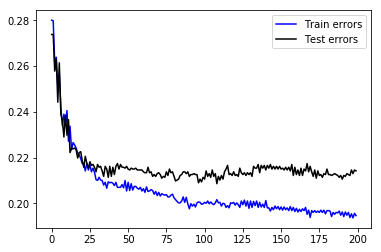

In [19]:
thet,featInd,threshs,sgns = stumpBooster(featuresTrain,labelsTrain,200)
plotErrorOverTime(featuresTrain,labelsTrain,featuresTest,labelsTest,thet,featInd,threshs,sgns)

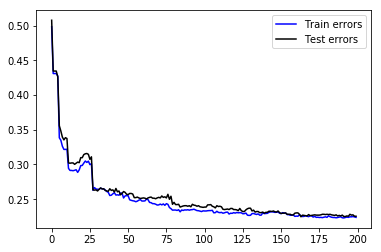

In [20]:
thetRand,featIndRand,threshsRand,sgnsRand = randomBooster(featuresTrain,labelsTrain,200)
plotErrorOverTime(featuresTrain,labelsTrain,featuresTest,labelsTest,thetRand,featIndRand,threshsRand,sgnsRand)

As we can see, optimal boosting fairly quickly (~25 iterations) converges to a training error below where the test eror bottoms out at around 22%. Random boosting converges towards the same performance, but much slower. Even after 200 iterations it has not converged to the minimum error